In [ ]:
import os, pathlib
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import eegbci
from mne.preprocessing import ICA, create_eog_epochs

In [ ]:
np.random.seed(42)

SUBJECT = 1              # 1..109
RUNS = [3, 4]            # try pairs like [3,4], [7,8], [11,12] (left vs right)
POWERLINE_FREQ = 60.0    # set to 50.0 in 50 Hz regions
BANDPASS = (1.0, 40.0)   # for MI (mu/beta); adjust to test other bands
EOG_CH = "Fp1"           # frontal channel used for blink detection (if present)

# Epoching settings
TMIN, TMAX = -1.0, 4.0
BASELINE = (None, 0.0)

In [4]:
# If your notebook lives in ./Notebooks, project_root = parent folder
project_root = pathlib.Path.cwd().parent
data_path = project_root / "data"
data_path.mkdir(exist_ok=True)

# Tell MNE to cache datasets here (prevents downloading to ~/mne_data)
mne.set_config("MNE_DATA", str(data_path), set_env=True)
mne.set_config("MNE_DATASETS_EEGBCI_PATH", str(data_path), set_env=True)

# Download/load EDF paths for this subject & runs (cached after first time)
paths = eegbci.load_data(subject=SUBJECT, runs=RUNS, path=str(data_path))
print("EDF files:")
for p in paths:
    sz_mb = os.path.getsize(p)/1e6
    print(f" - {pathlib.Path(p).name}  ({sz_mb:.1f} MB)")


EDF files:
 - S001R03.edf  (2.6 MB)
 - S001R04.edf  (2.6 MB)


In [5]:
# Read each EDF as a Raw object; keep the stimulus channel (“STI 014”) auto-detected
raws = [mne.io.read_raw_edf(p, preload=True, stim_channel="auto", verbose=False) for p in paths]

# Concatenate runs → one timeline for this subject (convenience)
raw = mne.concatenate_raws(raws)

# Standardize EEGBCI channel names, set electrode positions (10–20)
eegbci.standardize(raw)
raw.set_montage("standard_1020")

print(raw)  # summary: nchan, sfreq, duration
dur_min = raw.n_times / raw.info["sfreq"] / 60
print(f"Total duration ≈ {dur_min:.2f} min")

# Peek channel types
print("Channel types:", raw.get_channel_types())



<RawEDF | S001R03.edf, 64 x 40000 (250.0 s), ~19.6 MB, data loaded>
Total duration ≈ 4.17 min
Channel types: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']


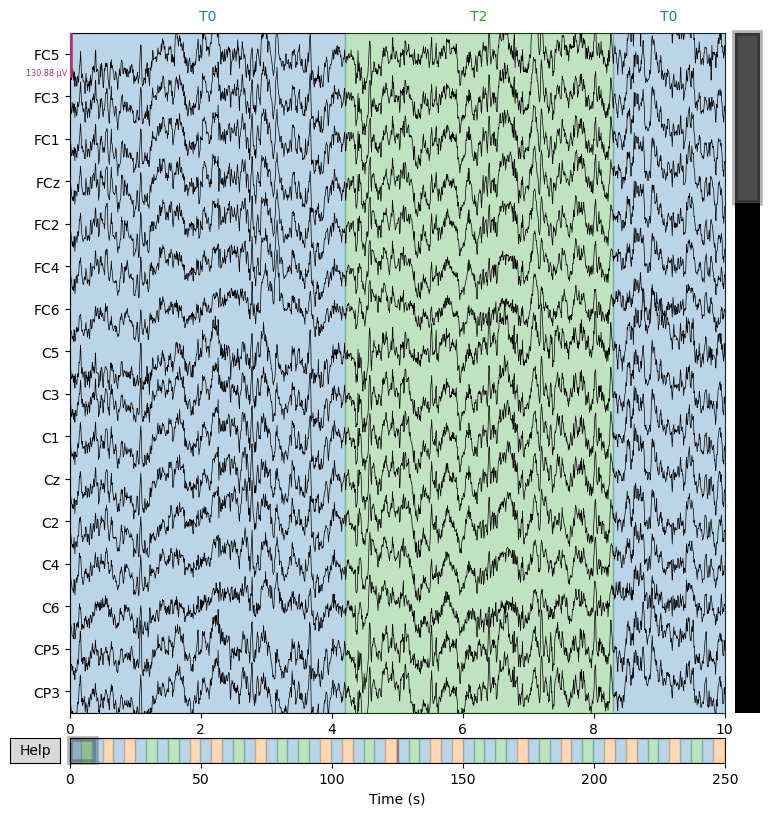

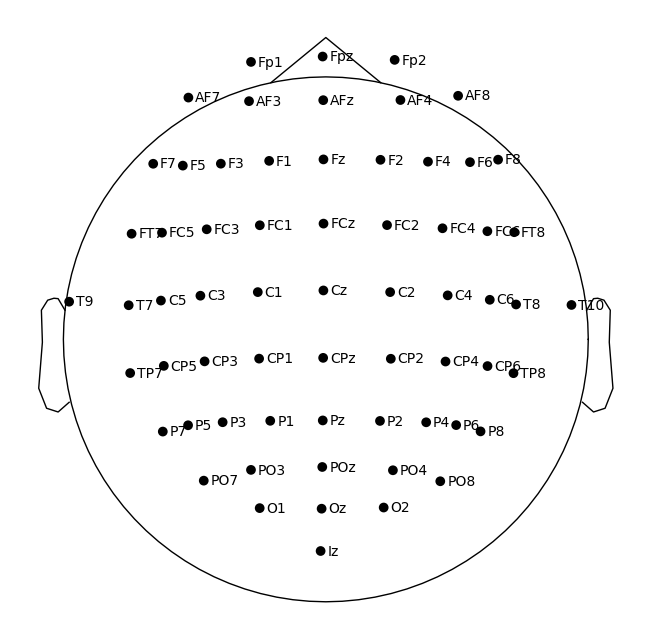

In [8]:
# Plot ~10 seconds of raw (scroll/zoom to explore)
raw.plot(start=0, duration=10, n_channels=16, scalings="auto",
         title="Raw EEG + Stim Channel (scrollable)")

# See where the electrodes are on the scalp
raw.plot_sensors(kind="topomap", show_names=True);


In [9]:
# Annotations are colored bands in raw.plot (rest/left/right etc.)
ann = raw.annotations
print(f"Annotations: {len(ann)} entries")
print("First few:", list(zip(ann.description[:8], ann.onset[:8], ann.duration[:8])))

# Convert annotations → events array
events, event_id_map = mne.events_from_annotations(raw)
print("Event ID map:", event_id_map)
print("First 10 events:\n", events[:10])

# Quick counts per label
vals, cnt = np.unique(events[:, 2], return_counts=True)
inv = {v: k for k, v in event_id_map.items()}
print({inv[v]: int(c) for v, c in zip(vals, cnt)})


Annotations: 62 entries
First few: [(np.str_('T0'), np.float64(0.0), np.float64(4.2)), (np.str_('T2'), np.float64(4.2), np.float64(4.1)), (np.str_('T0'), np.float64(8.3), np.float64(4.2)), (np.str_('T1'), np.float64(12.5), np.float64(4.1)), (np.str_('T0'), np.float64(16.6), np.float64(4.2)), (np.str_('T1'), np.float64(20.8), np.float64(4.1)), (np.str_('T0'), np.float64(24.9), np.float64(4.2)), (np.str_('T2'), np.float64(29.1), np.float64(4.1))]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Event ID map: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}
First 10 events:
 [[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]
 [3328    0    2]
 [3984    0    1]
 [4656    0    3]
 [5312    0    1]
 [5984    0    3]]
{np.str_('T0'): 30, np.str_('T1'): 16, np.str_('T2'): 14}


In [13]:
print("MNE version:", mne.__version__)

def plot_psd_overlay(raw_a, raw_b, labels=("A","B"), fmax=60):
    # New API (MNE ≥ 1.2): use object methods
    spec_a = raw_a.compute_psd(fmin=1, fmax=fmax, picks="eeg")
    spec_b = raw_b.compute_psd(fmin=1, fmax=fmax, picks="eeg")

    freqs = spec_a.freqs
    psd_a = spec_a.get_data().mean(axis=0)   # average over channels
    psd_b = spec_b.get_data().mean(axis=0)

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    ax.plot(freqs, psd_a, label=labels[0], alpha=0.85)
    ax.plot(freqs, psd_b, label=labels[1], alpha=0.85)
    ax.set(xlabel="Frequency (Hz)", ylabel="Power", title="PSD overlay")
    ax.legend(); ax.grid(alpha=0.3)
    plt.show()


MNE version: 1.8.0


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Effective window size : 12.800 (s)
Effective window size : 12.800 (s)


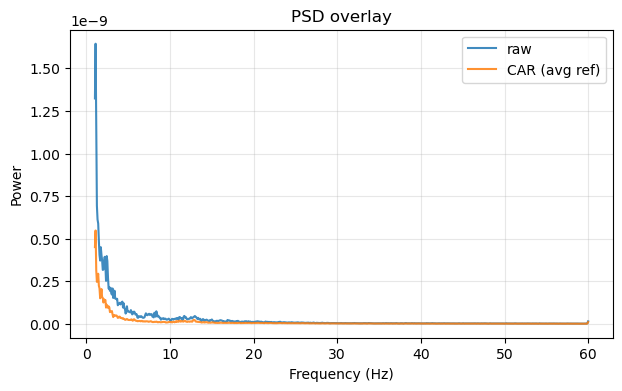

In [15]:
raw_orig = raw.copy()
raw_ref  = raw.copy().set_eeg_reference("average")
plot_psd_overlay(raw_orig, raw_ref, labels=("raw", "CAR (avg ref)"), fmax=60);


Filtering raw data in 2 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


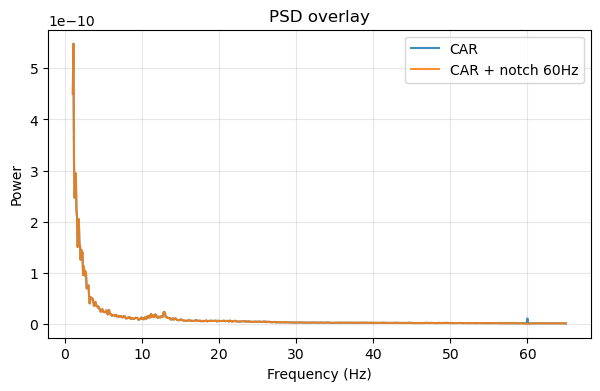

In [16]:
raw_notch = raw_ref.copy().notch_filter(freqs=[POWERLINE_FREQ], picks="eeg")

# Powerline peak should drop after notch
plot_psd_overlay(raw_ref, raw_notch, labels=("CAR", f"CAR + notch {int(POWERLINE_FREQ)}Hz"), fmax=65)


Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Effective window size : 12.800 (s)
Effective window size : 12.800 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


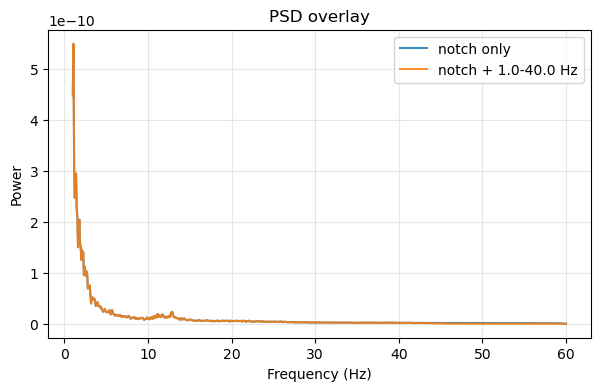

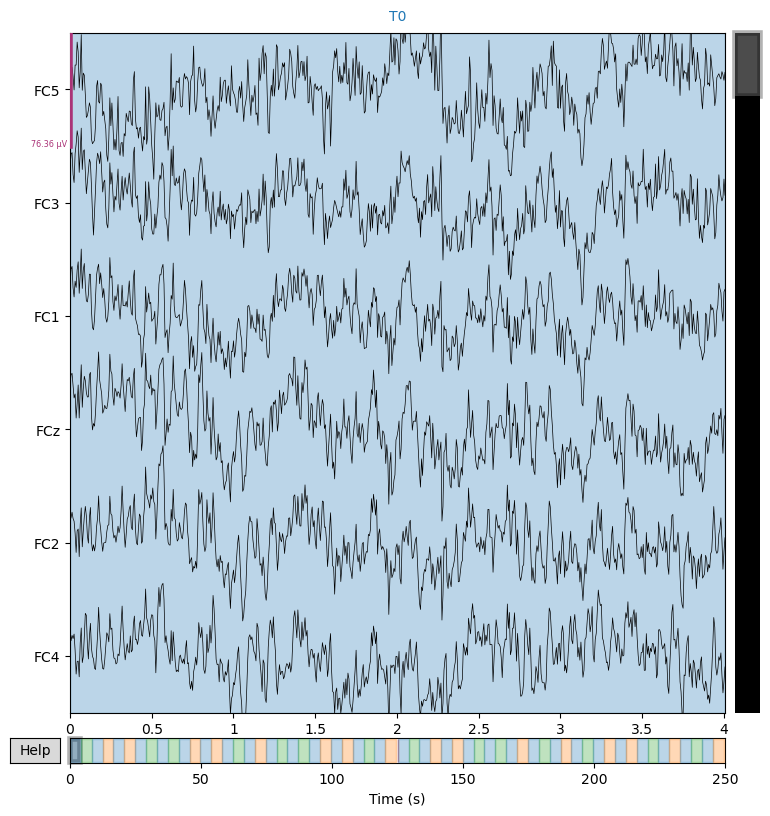

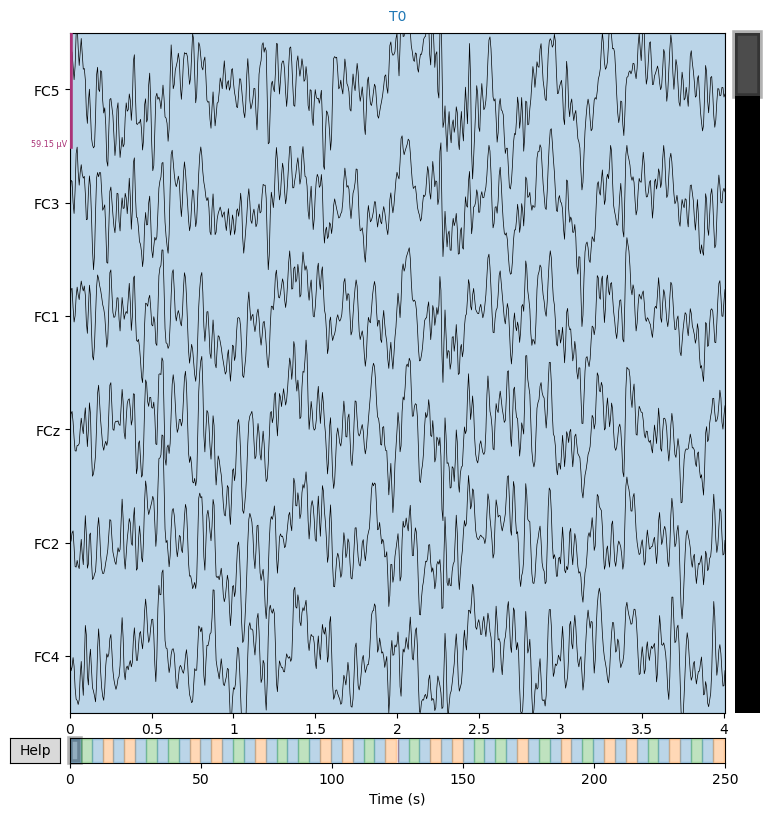

In [21]:
l_freq, h_freq = BANDPASS
raw_bp = raw_notch.copy().filter(l_freq=l_freq, h_freq=h_freq, picks="eeg")

# Compare PSD before vs after band-pass
plot_psd_overlay(raw_notch, raw_bp, labels=("notch only", f"notch + {l_freq}-{h_freq} Hz"), fmax=60);

# Visualize time-domain effect (cleaner rhythms / less drift & HF noise)
raw_notch.plot(start=0, duration=4, n_channels=6, scalings="auto",
               title="Before band-pass");
raw_bp.plot(start=0, duration=4, n_channels=6, scalings="auto",
            title=f"After band-pass {l_freq}-{h_freq} Hz");


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 4.5s.


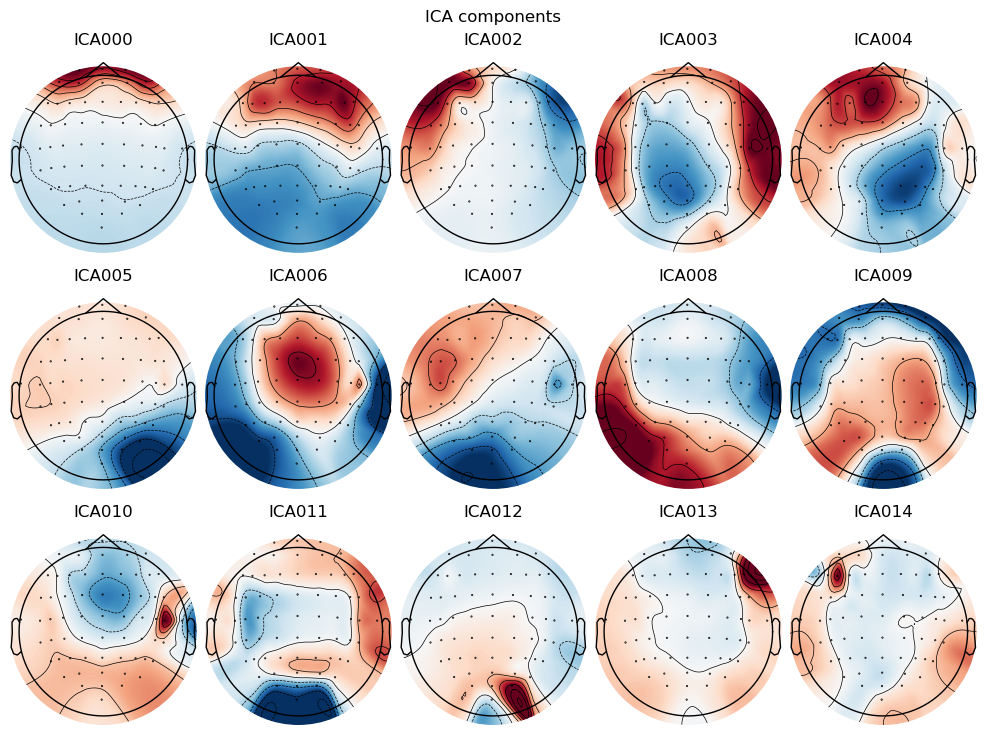

Using EOG channel: Fp1
EOG channel index for this subject is: [21]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 73 significant peaks
Number of EOG events detected: 73
Not setting metadata
73 matching events found
No baseline correction applied
Using data from preloaded Raw for 73 events and 161 original time points ...
0 bad epochs dropped
EOG detection skipped or channel 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


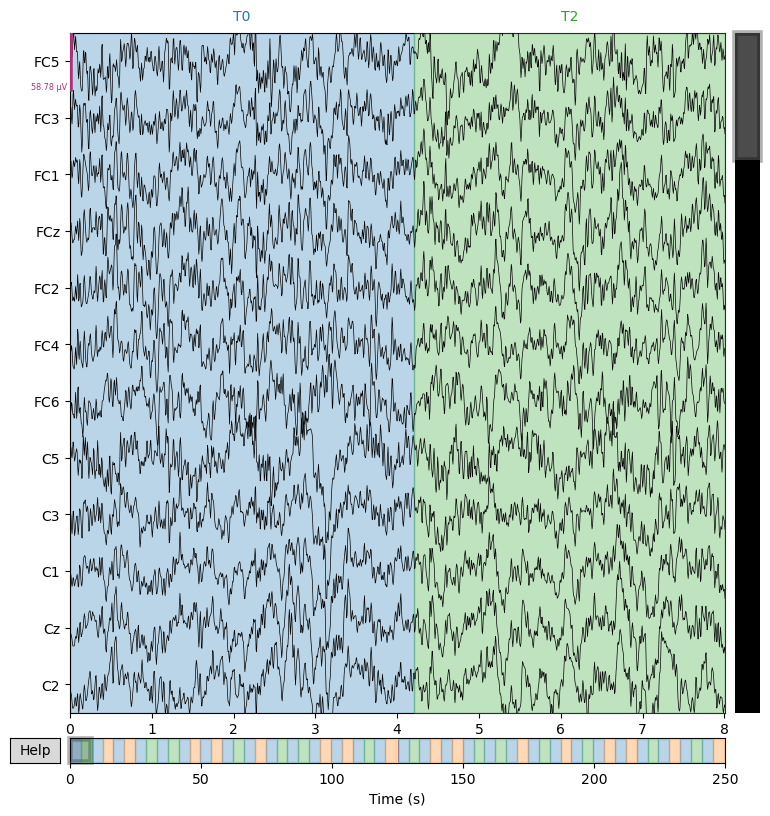

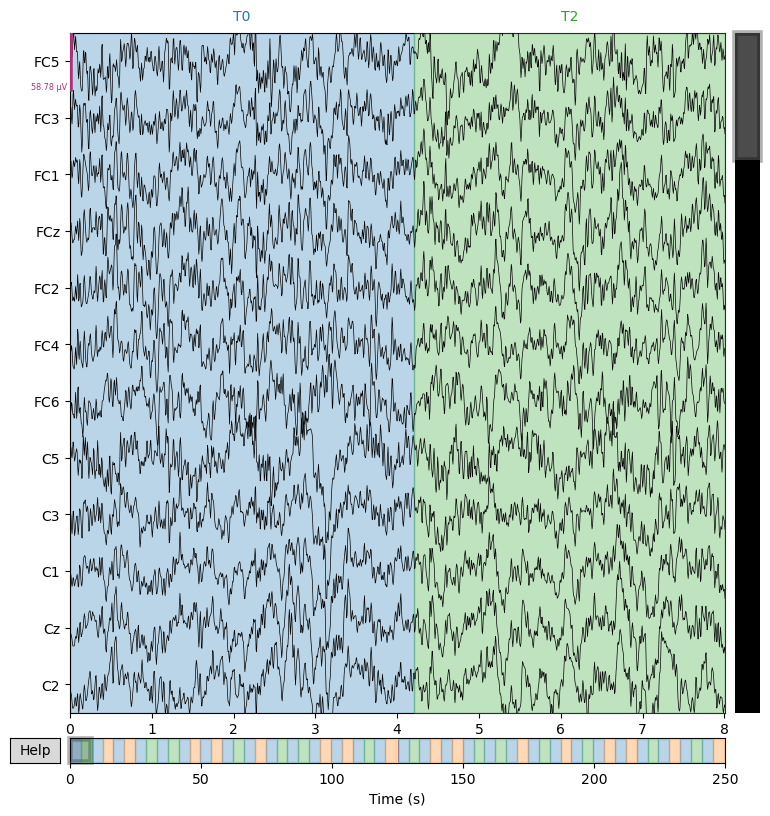

In [22]:
# Fit ICA on the band-passed data (1 Hz HP helps ICA separate blinks)
ica = ICA(n_components=15, random_state=97, max_iter="auto")
ica.fit(raw_bp)

# Visualize topographies of ICs (click to inspect)
ica.plot_components();

# Try to auto-detect EOG-related ICs using a frontal channel (adjust EOG_CH if needed)
try:
    eog_epochs = create_eog_epochs(raw_bp, ch_name=EOG_CH, reject_by_annotation=True)
    eog_inds, eog_scores = ica.find_bads_eog(eog_epochs)
    print("EOG-like ICs:", eog_inds)
    ica.exclude = eog_inds
except Exception as e:
    print("EOG detection skipped or channel missing:", e)

# Apply ICA (remove excluded components) to get a cleaned copy
raw_clean = raw_bp.copy()
ica.apply(raw_clean)

# Compare traces before vs after ICA
raw_bp.plot(start=0, duration=8, n_channels=12, scalings="auto",
            title="Before ICA (band-passed)");
raw_clean.plot(start=0, duration=8, n_channels=12, scalings="auto",
               title="After ICA (blink/artifact removed)");


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


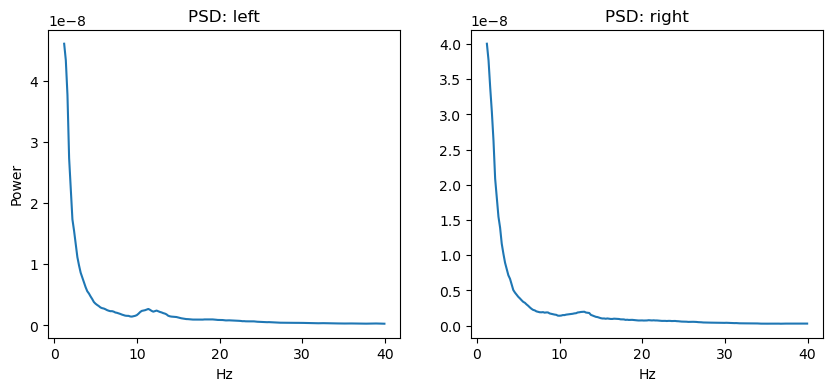

In [24]:
# Quick PSD per class (mu/beta should differ during MI)
spec_left  = epochs["left"].compute_psd(fmin=1, fmax=40)
spec_right = epochs["right"].compute_psd(fmin=1, fmax=40)

freqs = spec_left.freqs
# spec.get_data() shape: (n_epochs, n_channels, n_freqs)
psd_left  = spec_left.get_data().mean(axis=(0, 1))   # avg over epochs & channels
psd_right = spec_right.get_data().mean(axis=(0, 1))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(freqs, psd_left);  ax[0].set_title("PSD: left");  ax[0].set_xlabel("Hz"); ax[0].set_ylabel("Power")
ax[1].plot(freqs, psd_right); ax[1].set_title("PSD: right"); ax[1].set_xlabel("Hz")
plt.show()


In [ ]:
# proc_dir = project_root / "derivatives"
# proc_dir.mkdir(exist_ok=True)x

# f_raw_clean = proc_dir / f"sub-{SUBJECT:03d}_runs-{','.join(map(str,RUNS))}_rawclean.fif"
# f_epo = proc_dir / f"sub-{SUBJECT:03d}_runs-{','.join(map(str,RUNS))}_epochs-epo.fif"

# raw_clean.save(f_raw_clean, overwrite=True)
# epochs.save(f_epo, overwrite=True)

# print("Saved:", f_raw_clean)
# print("Saved:", f_epo)
